# Dirichlet Process

 Dirichlet Distribution: multi-variate generalization of beta   
    $ P \~ DP(\alpha,P_0)$ 
   where $P$ is a probability distribution in space $\Omega$
         $\alpha$ is scaling parameter 
         $P_0$ is the base distribution
 DP is a prior probability distribution in infinite mixture models. 
 DP : how likely it is that the random variables are 
      distributed according to one or another particular distribution
 Samples from DP are discrete with probability one. Thera are 
 elements $\omega_1,\omega_2,...$ in $\Omega$ and 
 weights $w_1,w_2,$ with $\sum_{i=1}^{\infty}$ such that 
        $ P = \sum_{i=1}^{\infty} w_i \delta_{\omega_i}
    where $\delta$ is the Dirac delta measure.

 http://blog.echen.me/2012/03/20/infinite-mixture-models-with-nonparametric-bayes-and-the-dirichlet-process/
 http://phyletica.org/dirichlet-process/
 https://github.com/tdhopper/notes-on-dirichlet-processes
 https://github.com/jzf2101/datamicroscopes

In [1]:
%matplotlib inline
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import scipy as sp
import seaborn as sns
import pandas as pd
from statsmodels.datasets import get_rdataset
from theano import tensor as tt

In [2]:
blue, *_ = sns.color_palette()
plt.style.use('seaborn')
sns.set_context("poster", font_scale=1.4)

In [3]:
SEED = 5132290 # from random.org

np.random.seed(SEED)

Stick Breaking Process : way of to construct weights  
   1 - Start a stick of length one 
   2 - Generate random variable $beta_1 ~ Beta(1,alpha)$, break off the 
     stick at $beta_1$; $w_1$ the length of the stick on the left 
   3 - Take the stick on the right, generate $beta_2 ~ Beta(1,alpha)$
     break off the stick at $beta_2$, $w_2=(1-beta_1)/beta_2$ 
     the length of the stick left 
 Other Methods: Chinese Restaurant Process, Polya Urn Scheme

  //generate wk according to SB with dispersion alpha, 
  //give each weight w_k to a group v_k ~ G0()
  //assign x_i to group v_k with probability w_k 

# Dirichlet Process Mixture

An Infitinite Mixture Models: assumes that the data 
comes from a mixture of an infinite number of distributions
DP Mixture uses component densities from 
a parametric family and represents the mixture weights as a DP. 

If $P_0$ is a probability measure on the parameter space 
   a DP mixture is the hierarchical model:  

\begin{align*}
 x_i |\theta_i   &\~ f_{\theta_i} \\
 \theta_1,...\theta_n &\~ P \\
  P &\~ DP(\alpha,P_0)
\end{align*}


# Real Data

In [4]:
sunspot_df = get_rdataset('sunspot.year', cache=True).data
sunspot_df.head()

,time,sunspot.year
0,1700,5.0
1,1701,11.0
2,1702,16.0
3,1703,23.0
4,1704,36.0


Model Example For Real Data: Sunspots per year

\begin{align*}
 \alpha & \~ Gamma(1,1)  \\
  \beta_1,...\beta_k &\~ Beta(1,\alpha) \\
  w_i &= \beta_i \prod_{j=i-1}^{i}(1-\beta_j)\\
    \lambda_1,...\lambda_k &\~ U(0,300) \\
    x|w_i,\lambda_i &\~ \sum_{i=1}^K w_i * Poisson(\lambda_i)
\end{align*}

In [5]:
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])

    return beta * portion_remaining

K = 50
N = sunspot_df.shape[0]
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    mu = pm.Uniform('mu', 0., 300., shape=K)
    obs = pm.Mixture('obs', w, pm.Poisson.dist(mu),  
                     observed=sunspot_df['sunspot.year'])


In [13]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, step=step, tune=90000, random_seed=SEED)

100%|██████████| 100000/100000 [05:22<00:00, 309.71it/s]


Parameters of the model 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f12f22780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0f2dc3a198>]], dtype=object)

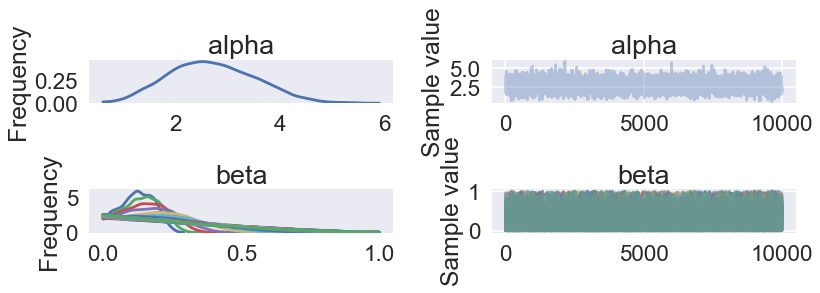

In [7]:
pm.traceplot(trace,varnames=['alpha','beta'])

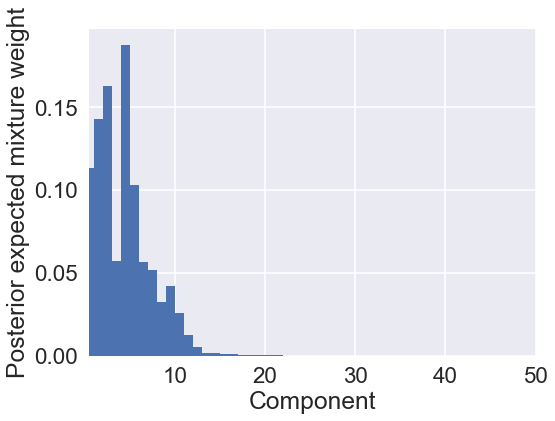

In [14]:
# Between ten-fifteen components 
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

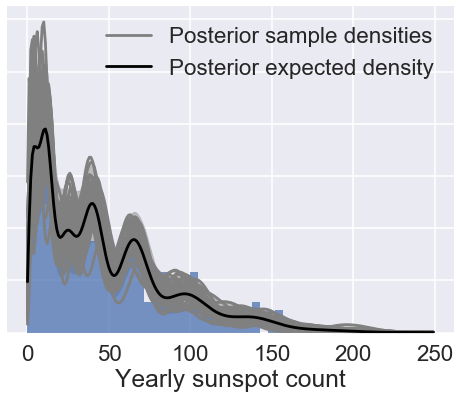

In [15]:
# Calculate density estimation 
x_plot = np.arange(250)
post_pmf_contribs = sp.stats.poisson.pmf(np.atleast_3d(x_plot),
                                         trace['mu'][:, np.newaxis, :])
post_pmfs = (trace['w'][:, np.newaxis, :] * post_pmf_contribs).sum(axis=-1)

post_pmf_low, post_pmf_high = np.percentile(post_pmfs, [2.5, 97.5], axis=0)


fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df['sunspot.year'].values, bins=40, normed=True, lw=0, alpha=0.75);

ax.fill_between(x_plot, post_pmf_low, post_pmf_high,
                 color='gray', alpha=0.45)
ax.plot(x_plot, post_pmfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pmfs[::200].T, c='gray');
ax.plot(x_plot, post_pmfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);

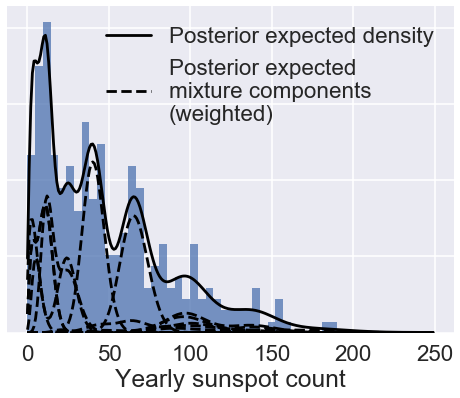

In [16]:
# Decompose the density into components 
fig, ax = plt.subplots(figsize=(8, 6))

ax.hist(sunspot_df['sunspot.year'].values, bins=40, normed=True, lw=0, alpha=0.75);
ax.plot(x_plot, post_pmfs.mean(axis=0),
        c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected\nmixture components\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pmf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Yearly sunspot count');
ax.set_yticklabels([]);
ax.legend(loc=1);

# IRIS Dataset 

In [17]:
import seaborn as sns
iris = sns.load_dataset('iris')
species = iris.species
covars = iris.drop('species', axis=1, inplace=False)

In [18]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


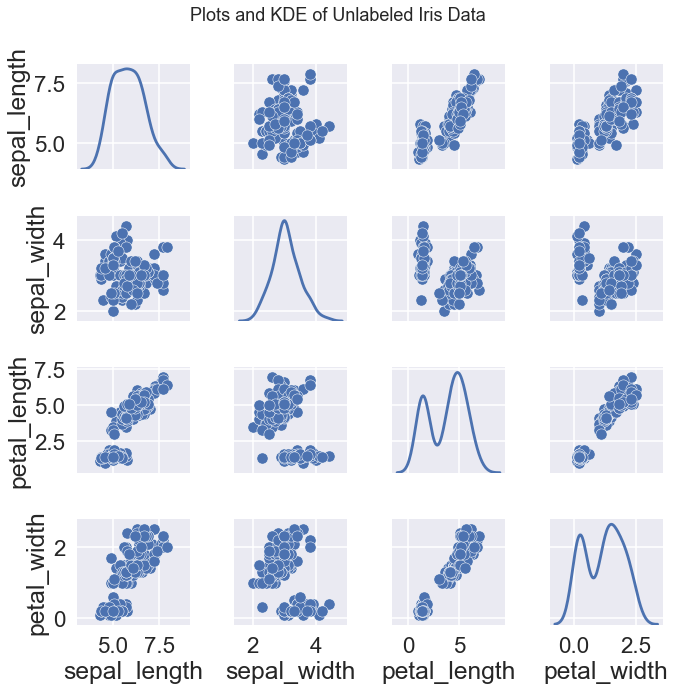

In [32]:
sns.pairplot(covars, diag_kind="kde", size=2.5)
plt.suptitle('Plots and KDE of Unlabeled Iris Data', fontsize = 18)
plt.subplots_adjust(top=.9)

Text(0,0.5,'Feature Value')

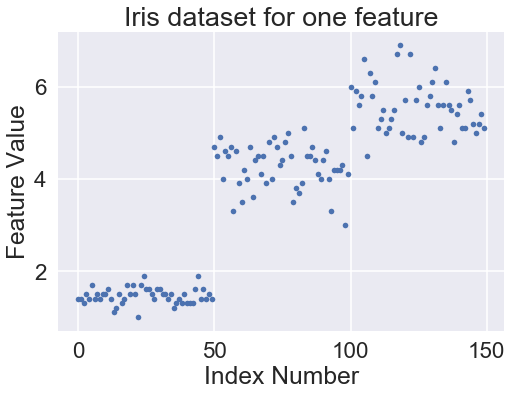

In [35]:
plt.plot(covars_matrix[:,2],'.')
plt.title("Iris dataset for one feature")
plt.xlabel('Index Number')
plt.ylabel('Feature Value')

In [20]:
covars_matrix = covars.as_matrix()
K = 30 
N = covars_matrix.shape[0]

Example Model for Iris Dataset
\begin{align*}
  \alpha & \~ Gamma(1,1)  \\
  \beta_1,...\beta_k &\~ Beta(1,\alpha) \\
  w_i &= \beta_i \prod_{j=i-1}^{i}(1-\beta_j)\\
    \lambda_1,...\lambda_k &\~ U(0,5) \\
    \tau_1,...,\tau_k &\~ Gamma(1,1) \\
    \mu_i | \lambda_i,\tau_K &\~ N(0,(\lambda_i\tau_i)^{-1}) \\
    x|w_i,\lambda_i,\tau_i,\mu_i &\~ \sum_{i=1}^K w_i * N(\mu_i,(\lambda_i\tau_i)^{-1})
\end{align*}

In [21]:
with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, tau=lambda_ * tau, shape=K)
    obs = pm.NormalMixture('obs', w, mu, tau=lambda_ * tau,
                           observed=covars_matrix[:,2])

In [28]:
with model:
    trace = pm.sample(5000, random_seed=SEED,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 5998/6000 [02:36<00:00, 38.36it/s]/home/usernobody/miniconda2/envs/pystan/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:451: UserWarning: The acceptance probability in chain 0 does not match the target. It is 0.881906255701, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
/home/usernobody/miniconda2/envs/pystan/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 687 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 6000/6000 [02:36<00:00, 38.36it/s]


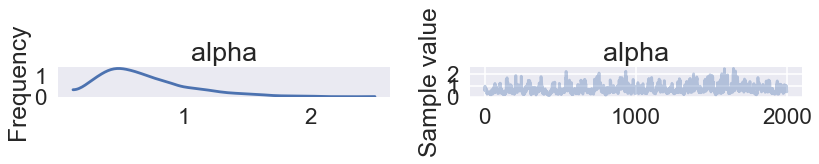

In [23]:
pm.traceplot(trace, varnames=['alpha']);

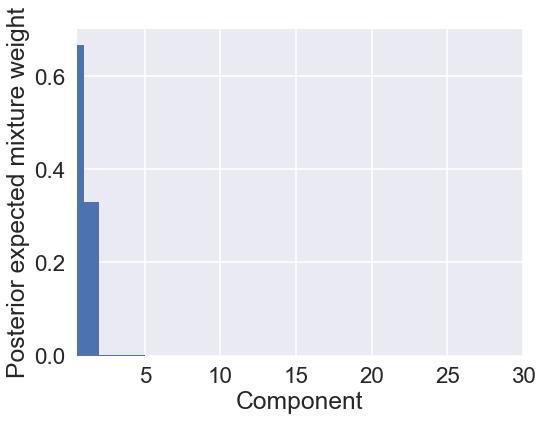

In [29]:
# Mixture Weights 
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1

ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);

ax.set_xlim(0.5, K);
ax.set_xlabel('Component');

ax.set_ylabel('Posterior expected mixture weight');

In [30]:
x_plot = np.linspace(-2, 8, 200)

post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

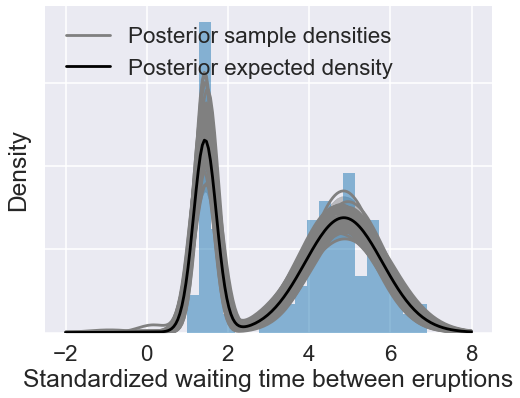

In [36]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(covars_matrix[:,2], bins=n_bins, normed=True,
        color=blue, lw=0, alpha=0.5);

ax.fill_between(x_plot, post_pdf_low, post_pdf_high,
                color='gray', alpha=0.45);
ax.plot(x_plot, post_pdfs[0],
        c='gray', label='Posterior sample densities');
ax.plot(x_plot, post_pdfs[::100].T, c='gray');
ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);

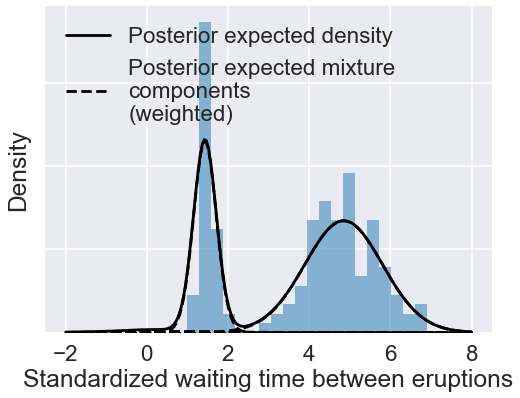

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(covars_matrix[:,2], bins=n_bins, normed=True,
        color=blue, lw=0, alpha=0.5);

ax.plot(x_plot, post_pdfs.mean(axis=0),
        c='k', label='Posterior expected density');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);

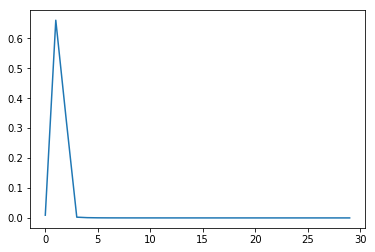

In [107]:
pltplot(trace['w'].mean(axis=0))

In [40]:
from pymc3.math import logsumexp 
from theano.tensor.nlinalg import det

# loglikelihood of normal distribution 
def logp_normal(mu,tau,value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu 
    return (-1 / 2.) * (k * tt.log(2 * np.pi) + tt.log(1./det(tau)) +
                         (delta(mu).dot(tau) * delta(mu)).sum(axis=1))

# log likelihood of GMM 
def logp_gmix(mus,pi,tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value)
                 for i, mu in enumerate(mus)]
        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))
    
    return logp_ 

# Define model 
n_samples = 5000
ndim = 2
k = 3
data = covars_matrix[:,0:2]
with pm.Model() as model2d:
    mus = [pm.MvNormal('mu_%d'%i,
                      mu=pm.floatX(np.zeros(ndim)),
                      tau=pm.floatX(0.1*np.eye(ndim)),
                      shape=(ndim,))
          for i in range(k)]
    pi = pm.Dirichlet('pi',a=pm.floatX(0.1*np.ones(k)),shape=(k,))
    xs = pm.DensityDist('x',logp_gmix(mus,pi,np.eye(ndim)),observed=data)

In [41]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, tune=90000, random_seed=SEED)

100%|██████████| 100000/100000 [04:34<00:00, 364.72it/s]


In [43]:
model = pm.Model()
ndata=150
with model:
    # cluster sizes 
    p = pm.Dirichlet('p',a=np.array([1.,1.,1.]),shape=3)
    # ensure all clusters have some points 
    p_min_potential = pm.Potential('p_min_potential',tt.switch(tt.min(p)<.1,-np.inf,0))
    
    # cluster centers 
    means = pm.Normal('means',mu=[0,0,0],sd=15,shape=k)
    # break symetry 
    order_means_potential = pm.Potential('order_means_potenatial',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))
    # measurement error 
    sd = pm.Uniform('sd',lower=0,upper=20)
    
    # latent cluster of each observation 
    category = pm.Categorical('category',p=p,shape=ndata)
    
    # likelihood for each observed value 
    points = pm.Normal('obs',mu=means[category],sd=sd,observed=covars_matrix[:,2])

In [44]:
with model2:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, tune=90000, random_seed=SEED)

100%|██████████| 100000/100000 [01:03<00:00, 1580.11it/s]


In [45]:
trace.varnames

['p_stickbreaking__', 'means', 'sd_interval__', 'p', 'sd']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0eeb4d7e80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f0ef328f358>]], dtype=object)

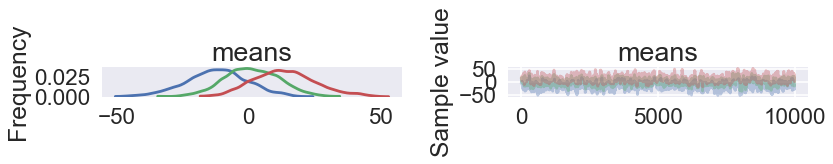

In [50]:
pm.plots.traceplot(trace,['means'])